In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 0. Data Preparation

## 0.1. Read Data

In [2]:
df = pd.read_excel("TBA_mod.xlsx")  # TBA
FN_issue = pd.read_csv("FN_issuance.csv")  # issuance 
rr_daily = pd.read_excel("ILM3NAVG_daily.xlsx") # Use Bankrate.com US Home Mortgage 30year Fixed Natinal Avg
TR_10 = pd.read_excel("USGG10YR.xlsx")

#TR_10.head()

## 0.2. Clean Data

In [54]:
l = df.loc[0].values
c = df.columns
for ind in np.arange(8)*3:
    l[ind] = c[ind]

df.columns = l
df.drop(0)
FN_issue.index = FN_issue['Date']
del FN_issue['Date']
rr_daily.index = rr_daily['Date']
del rr_daily['Date']
rr_daily.columns = ['Last rate', 'Mid rate']
TR_10.index = TR_10['Date']
del TR_10["Date"]
TR_10.columns = ['10 year rate']

# FN_issue.head()

**For each month find the max issuance bond and use this to generate the price and yield relation**

In [24]:
Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))

**Plot the monthly most issued coupon rate vs. reference rate**

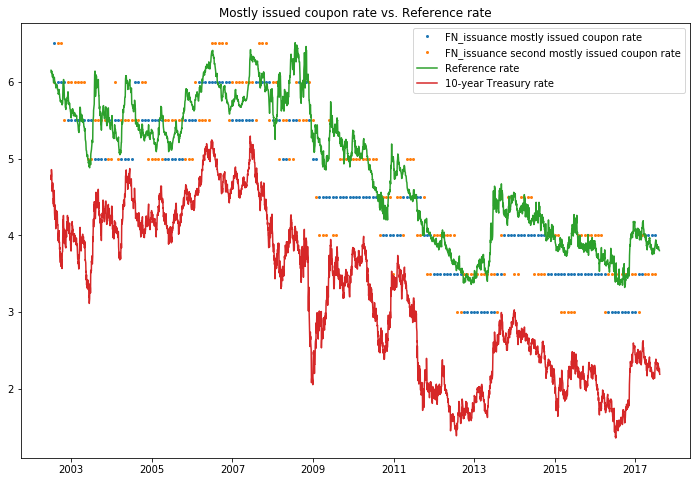

In [25]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot_date(FN_issue.index, Second_Most_issued, label = 'FN_issuance second mostly issued coupon rate', markersize = 2)
#ax.plot_date(FN_issue.index, Third_Most_issued, label = 'FN_issuance Third mostly issued coupon rate', markersize = 2)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.plot_date(TR_10.index, TR_10['10 year rate'],'-',label = '10-year Treasury rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

From graph above, we would like to use same coupon for regression as long as possible. 

In general, there is a rate drop from 6% to 3%. We then cut the entire time frame into three parts.

First part from begin to about late 2008, use coupon 5.5% as representative.

Second part, we use coupon 4.5% for the middle part of our time series.

Final part, the low rate part, we would like to use 3.5% 

The detailed cutoff time will be determined in the next cell.

**TBA data at each coupon rate**

In [64]:
FNCL3 = df.iloc[:,:3].drop(0).dropna().copy()
FNCL3.index = FNCL3['FNCL 3.0 Mtge']
del FNCL3['FNCL 3.0 Mtge']

FNCL3_5 = df.iloc[:,3:6].drop(0).dropna().copy()
FNCL3_5.index = FNCL3_5['FNCL 3.5 Mtge']
del FNCL3_5['FNCL 3.5 Mtge']

FNCL4 = df.iloc[:,6:9].drop(0).dropna().copy()
FNCL4.index = FNCL4['FNCL 4 Mtge']
del FNCL4['FNCL 4 Mtge']

FNCL4_5 = df.iloc[:,9:12].drop(0).dropna().copy()
FNCL4_5.index = FNCL4_5['FNCL 4.5 Mtge']
del FNCL4_5['FNCL 4.5 Mtge']

FNCL5 = df.iloc[:,12:15].drop(0).dropna().copy()
FNCL5.index = FNCL5['FNCL 5 Mtge']
del FNCL5['FNCL 5 Mtge']

FNCL5_5 = df.iloc[:,15:18].drop(0).dropna().copy()
FNCL5_5.index = FNCL5_5['FNCL 5.5 Mtge']
del FNCL5_5['FNCL 5.5 Mtge']

FNCL6 = df.iloc[:,18:21].drop(0).dropna().copy()
FNCL6.index = FNCL6['FNCL 6 Mtge']
del FNCL6['FNCL 6 Mtge']

FNCL6_5 = df.iloc[:,21:].drop(0).dropna().copy()
FNCL6_5.index = FNCL6_5['FNCL 6.5 Mtge']
del FNCL6_5['FNCL 6.5 Mtge']

list_df = [FNCL3, FNCL3_5, FNCL4 , FNCL4_5, FNCL5, FNCL5_5, FNCL6, FNCL6_5]

ind = [int(i-3)*2 for i in Most_issue]

**TBA data to use in each time period. Pick the TBA data with coupon = mostly issued coupon rate at each time point**

In [27]:
totel = []
for t, i in zip(FN_issue.index, ind):
    t1 = dt.datetime.strptime(t,'%d-%b-%y')
    t_end = t1 + dt.timedelta(1)
    t_start = dt.datetime(t1.year,t1.month,1) - dt.timedelta(1)
    
    temp =  list_df[i].iloc[(list_df[i].index > t_start) & (list_df[i].index < t_end)].copy()
    temp['coupon'] = i/2 +3
    totel.append(temp)

result = pd.concat(totel)

In [28]:
First_Part_5_5 = FNCL5_5.ix[FNCL5_5.index < '2008-11-28'].copy()
Second_Part_4_5 = FNCL4_5.ix[(FNCL4_5.index < '2011-12-31') & (FNCL4_5.index > '2008-11-27')].copy()
Third_Part_3_5 = FNCL3_5.ix[(FNCL3_5.index > '2011-12-30')].copy()


New_F = pd.concat([First_Part_5_5, TR_10], axis=1, join='inner')
New_F['coupon'] = 5.5
New_F['Spread'] = New_F['coupon']- New_F['10 year rate']
#print New_F.head()


New_S = pd.concat([Second_Part_4_5, TR_10], axis=1, join='inner')
New_S['coupon'] = 4.5
New_S['Spread'] = New_S['coupon']- New_S['10 year rate']
#print New_S.head()


New_T = pd.concat([Third_Part_3_5, TR_10], axis=1, join='inner')
New_T['coupon'] = 3.5
New_T['Spread'] = New_T['coupon']- New_T['10 year rate']
#print New_T.head()

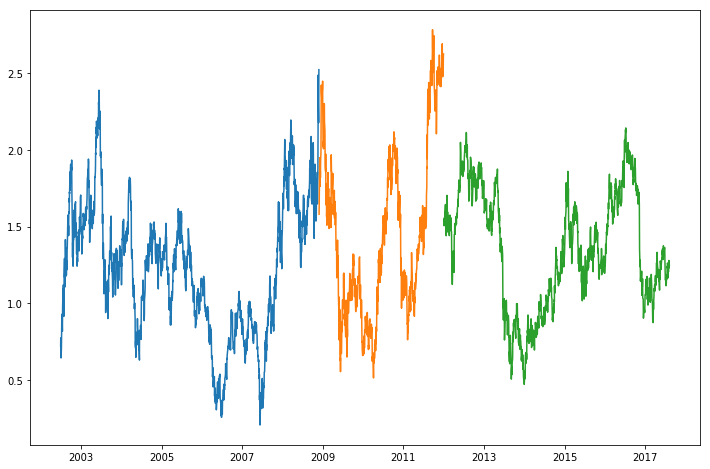

In [33]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(New_F.index, New_F['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot(New_S.index, New_S['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot(New_T.index, New_T['Spread'], label = 'FN_issuance mostly issued coupon rate', markersize = 2)

**Price change**

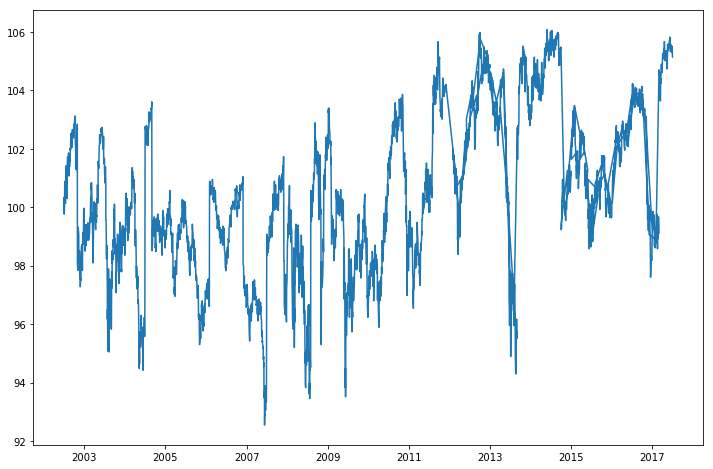

In [8]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(result['PX_MID'])

**Merge TBA data with reference rate data**

Here we define a new data column **spread** = Reference Rate - Coupon Rate. Our yearly rolling regression will be based on this spread

In [9]:
Merged_df = pd.concat([rr_daily, result], axis=1, join='inner')
Merged_df['spread'] = Merged_df['Last rate'] - Merged_df['coupon']
Merged_df['year'] = Merged_df.index.year

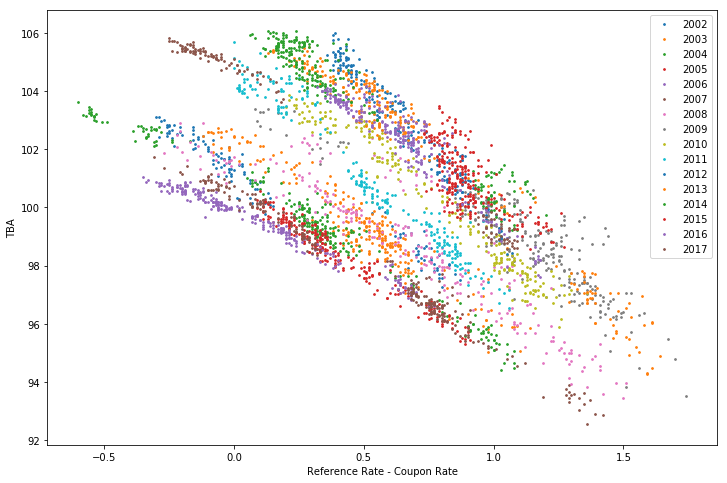

In [10]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
for y in np.arange(2002, 2018):
    ax.scatter(Merged_df[Merged_df.year == y]['spread'],Merged_df[Merged_df.year == y]['PX_MID'], s = 3, label = y)
ax.legend()
ax.set_xlabel('Reference Rate - Coupon Rate')
ax.set_ylabel('TBA')

## 0.3. Data Exploration

In [85]:
TR_10_2 = pd.read_excel("USGG10YR.xlsx")
TR10=TR_10_2.set_index(TR_10["Date"])
del TR10["Date"]
TR10.columns = ['10YR']
df_base=TR10.sort_index(axis=0,ascending=True)

df2 = pd.read_excel("TBA_mod.xlsx")

FNCL3_2 = df2.iloc[:,:2].drop(0).dropna().copy()
FNCL3_2.index = FNCL3_2['FNCL 3.0 Mtge']
del FNCL3_2['FNCL 3.0 Mtge']
FNCL3_2.columns = ['Price3']

FNCL3_5_2 = df2.iloc[:,3:5].drop(0).dropna().copy()
FNCL3_5_2.index = FNCL3_5_2['FNCL 3.5 Mtge']
del FNCL3_5_2['FNCL 3.5 Mtge']
FNCL3_5_2.columns = ['Price3.5']

FNCL4_2 = df2.iloc[:,6:8].drop(0).dropna().copy()
FNCL4_2.index = FNCL4_2['FNCL 4 Mtge']
del FNCL4_2['FNCL 4 Mtge']
FNCL4_2.columns = ['Price4']

FNCL4_5_2 = df2.iloc[:,9:11].drop(0).dropna().copy()
FNCL4_5_2.index = FNCL4_5_2['FNCL 4.5 Mtge']
del FNCL4_5_2['FNCL 4.5 Mtge']
FNCL4_5_2.columns = ['Price4.5']

FNCL5_2 = df2.iloc[:,12:14].drop(0).dropna().copy()
FNCL5_2.index = FNCL5_2['FNCL 5 Mtge']
del FNCL5_2['FNCL 5 Mtge']
FNCL5_2.columns = ['Price5']

FNCL5_5_2 = df2.iloc[:,15:17].drop(0).dropna().copy()
FNCL5_5_2.index = FNCL5_5_2['FNCL 5.5 Mtge']
del FNCL5_5_2['FNCL 5.5 Mtge']
FNCL5_5_2.columns = ['Price5.5']

FNCL6_2 = df2.iloc[:,18:20].drop(0).dropna().copy()
FNCL6_2.index = FNCL6_2['FNCL 6 Mtge']
del FNCL6_2['FNCL 6 Mtge']
FNCL6_2.columns = ['Price6']

FNCL6_5_2 = df2.iloc[:,21:23].drop(0).dropna().copy()
FNCL6_5_2.index = FNCL6_5_2['FNCL 6.5 Mtge']
del FNCL6_5_2['FNCL 6.5 Mtge']
FNCL6_5_2.columns = ['Price6.5']

In [86]:
df_base=df_base.merge(FNCL3_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL3_5_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL4_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL4_5_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL5_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL5_5_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL6_2,how='left',left_index=True, right_index=True)
df_base=df_base.merge(FNCL6_5_2,how='left',left_index=True, right_index=True)
df_base["spread3"]=(3-df_base["10YR"])/100
df_base["spread3_5"]=(3.5-df_base["10YR"])/100
df_base["spread4"]=(4-df_base["10YR"])/100
df_base["spread4_5"]=(4.5-df_base["10YR"])/100
df_base["spread5"]=(5-df_base["10YR"])/100
df_base["spread5_5"]=(5.5-df_base["10YR"])/100
df_base["spread6"]=(6-df_base["10YR"])/100
df_base["spread6_5"]=(6.5-df_base["10YR"])/100
df_base.head()

,10YR,Price3,Price3.5,Price4,Price4.5,Price5,Price5.5,Price6,Price6.5,spread3,spread3_5,spread4,spread4_5,spread5,spread5_5,spread6,spread6_5
Date,,,,,,,,,,,,,,,,,
2002-07-01,4.7802,NaN,NaN,NaN,NaN,NaN,97.2344,100.047,102.203,-0.017802,-0.012802,-0.007802,-0.002802,0.002198,0.007198,0.012198,0.017198
2002-07-02,4.7254,NaN,NaN,NaN,NaN,NaN,97.5781,100.328,102.391,-0.017254,-0.012254,-0.007254,-0.002254,0.002746,0.007746,0.012746,0.017746
2002-07-03,4.7639,NaN,NaN,NaN,NaN,NaN,97.3906,100.141,102.266,-0.017639,-0.012639,-0.007639,-0.002639,0.002361,0.007361,0.012361,0.017361
2002-07-04,4.7618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017618,-0.012618,-0.007618,-0.002618,0.002382,0.007382,0.012382,0.017382
2002-07-05,4.8560,NaN,NaN,NaN,NaN,NaN,96.8594,99.7656,101.922,-0.018560,-0.013560,-0.008560,-0.003560,0.001440,0.006440,0.011440,0.016440


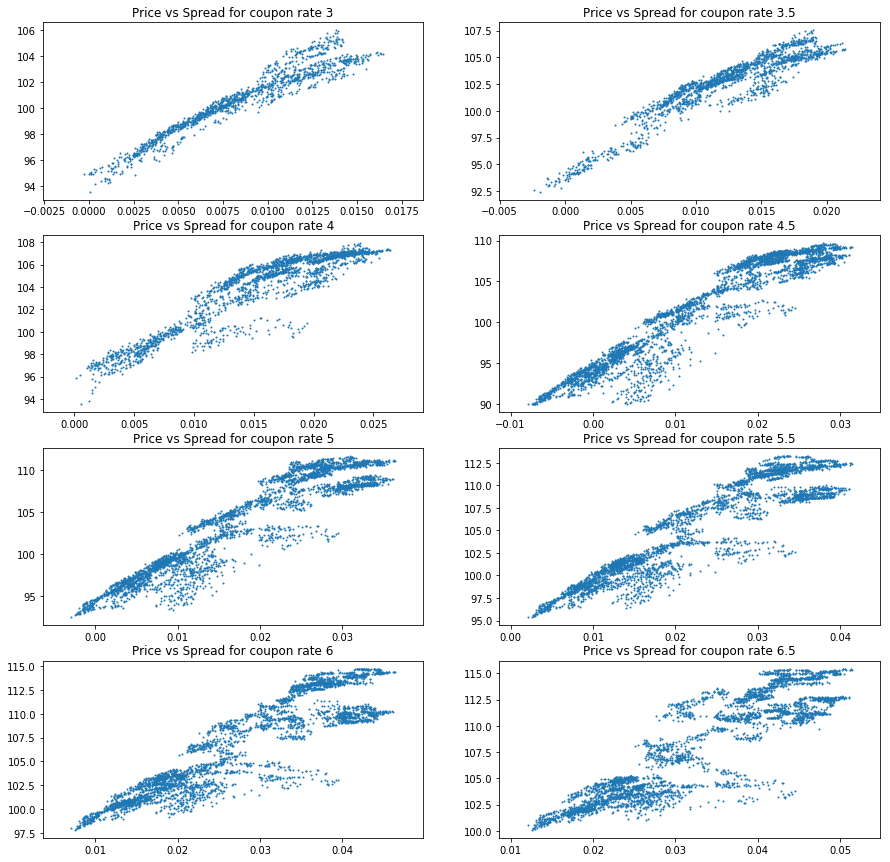

In [87]:
f, axarr = plt.subplots(4, 2,figsize=(15,15))
axarr[0, 0].scatter(df_base['spread3'].values,df_base['Price3'].values,s=1)
axarr[0, 0].set_title('Price vs Spread for coupon rate 3')
axarr[0, 1].scatter(df_base['spread3_5'].values,df_base['Price3.5'].values,s=1)
axarr[0, 1].set_title('Price vs Spread for coupon rate 3.5')
axarr[1, 0].scatter(df_base['spread4'].values,df_base['Price4'].values,s=1)
axarr[1, 0].set_title('Price vs Spread for coupon rate 4')
axarr[1, 1].scatter(df_base['spread4_5'].values,df_base['Price4.5'].values,s=1)
axarr[1, 1].set_title('Price vs Spread for coupon rate 4.5')
axarr[2, 0].scatter(df_base['spread5'].values,df_base['Price5'].values,s=1)
axarr[2, 0].set_title('Price vs Spread for coupon rate 5')
axarr[2, 1].scatter(df_base['spread5_5'].values,df_base['Price5.5'].values,s=1)
axarr[2, 1].set_title('Price vs Spread for coupon rate 5.5')
axarr[3, 0].scatter(df_base['spread6'].values,df_base['Price6'].values,s=1)
axarr[3, 0].set_title('Price vs Spread for coupon rate 6')
axarr[3, 1].scatter(df_base['spread6_5'].values,df_base['Price6.5'].values,s=1)
axarr[3, 1].set_title('Price vs Spread for coupon rate 6.5')
plt.show()

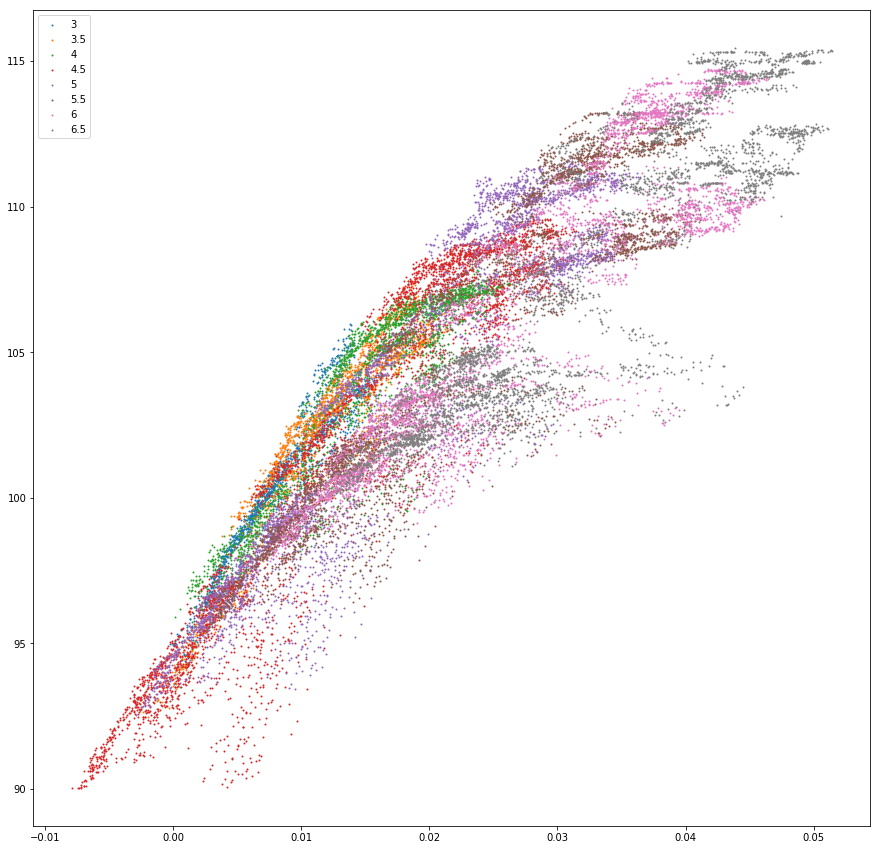

In [90]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.scatter(df_base['spread3'].values,df_base['Price3'].values,s=1, label='3')
ax.scatter(df_base['spread3_5'].values,df_base['Price3.5'].values,s=1,label='3.5')
ax.scatter(df_base['spread4'].values,df_base['Price4'].values,s=1,label='4')
ax.scatter(df_base['spread4_5'].values,df_base['Price4.5'].values,s=1,label='4.5')
ax.scatter(df_base['spread5'].values,df_base['Price5'].values,s=1,label='5')
ax.scatter(df_base['spread5_5'].values,df_base['Price5.5'].values,s=1,label='5.5')
ax.scatter(df_base['spread6'].values,df_base['Price6'].values,s=1,label='6')
ax.scatter(df_base['spread6_5'].values,df_base['Price6.5'].values,s=1,label='6.5')
plt.legend()

1) Before 2009, use coupon rate 6,5.5,5
<br>
2) 2009-2012, use coupon rate 4.5
<br>
3) 2010-2017, use coupon rate 4
<br>
4) 2012-2017, use coupon rate 3.5
<br>
5) 2013-2017, use coupon rate 3

In [8]:
df_clean=df_base.copy(deep=True)
df_clean["year"]=df_clean.index.year
df_clean.head()

,10YR,Price3,Price3.5,Price4,Price4.5,Price5,Price5.5,Price6,Price6.5,spread3,spread3_5,spread4,spread4_5,spread5,spread5_5,spread6,spread6_5,year
Date,,,,,,,,,,,,,,,,,,
2002-07-01,4.7802,NaN,NaN,NaN,NaN,NaN,97.2344,100.047,102.203,-0.017802,-0.012802,-0.007802,-0.002802,0.002198,0.007198,0.012198,0.017198,2002
2002-07-02,4.7254,NaN,NaN,NaN,NaN,NaN,97.5781,100.328,102.391,-0.017254,-0.012254,-0.007254,-0.002254,0.002746,0.007746,0.012746,0.017746,2002
2002-07-03,4.7639,NaN,NaN,NaN,NaN,NaN,97.3906,100.141,102.266,-0.017639,-0.012639,-0.007639,-0.002639,0.002361,0.007361,0.012361,0.017361,2002
2002-07-04,4.7618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017618,-0.012618,-0.007618,-0.002618,0.002382,0.007382,0.012382,0.017382,2002
2002-07-05,4.8560,NaN,NaN,NaN,NaN,NaN,96.8594,99.7656,101.922,-0.018560,-0.013560,-0.008560,-0.003560,0.001440,0.006440,0.011440,0.016440,2002


In [9]:
df_1=df_clean.loc['7-Jan-00':'28-Nov-08']
df1=df_1.ix[:,['Price6','Price5.5','Price5',"spread6","spread5_5","spread5","year"]]
df_2=df_clean.loc['28-Nov-08':'30-Dec-11']
df2=df_2.ix[:,['Price4.5',"spread4_5","year"]]
df_3=df_clean.loc['30-Dec-11':'8-Aug-17']
df3=df_3.ix[:,['Price4','Price3.5','Price3',"spread4","spread3_5","spread3","year"]]

In [10]:
def plot_setting(data,x,y,title):
    x=data[x]
    y=data[y]
    labels = data['year']
    df = pd.DataFrame(dict(x=x, y=y, label=labels)).copy()
    groups = df.groupby('label')   
    # Plot
    colorlimit=len(data['year'].unique()) 
    plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')
    ax.set_color_cycle(colors)
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='',ms=3, label=name)
    ax.legend(numpoints=1)
    plt.title(title)
    plt.xlabel('Spread')
    plt.ylabel('Price')
    return None;

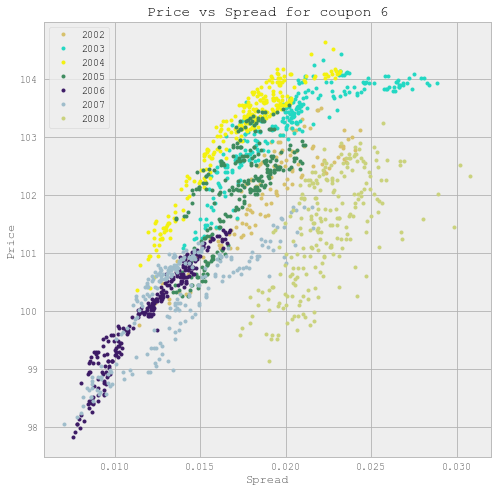

In [11]:
plot_setting(data=df_1,x="spread6",y='Price6',title='Price vs Spread for coupon 6')
plt.show()

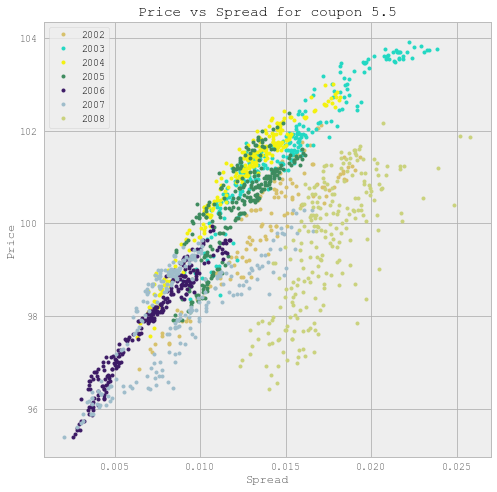

In [12]:
plot_setting(data=df_1,x="spread5_5",y='Price5.5',title='Price vs Spread for coupon 5.5')
plt.show()

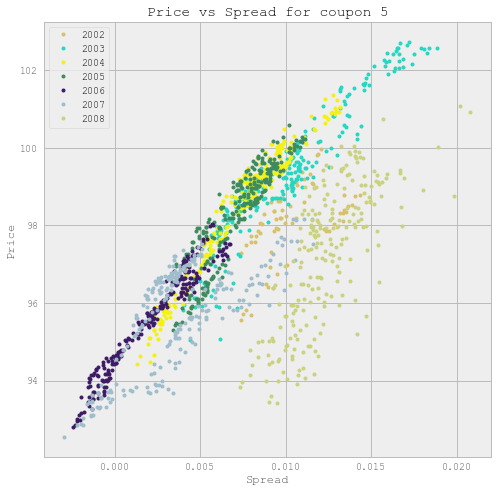

In [13]:
plot_setting(data=df_1,x="spread5",y='Price5',title='Price vs Spread for coupon 5')
plt.show()

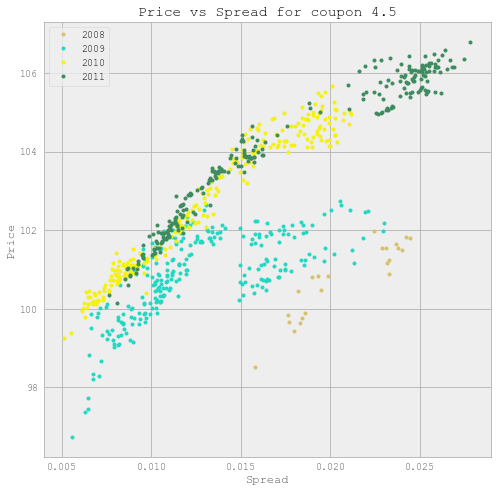

In [14]:
plot_setting(data=df_2,x="spread4_5",y='Price4.5',title='Price vs Spread for coupon 4.5')
plt.show()

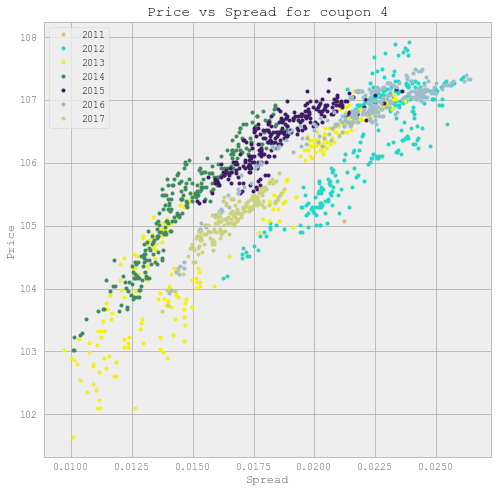

In [15]:
plot_setting(data=df_3,x="spread4",y='Price4',title='Price vs Spread for coupon 4')
plt.show()

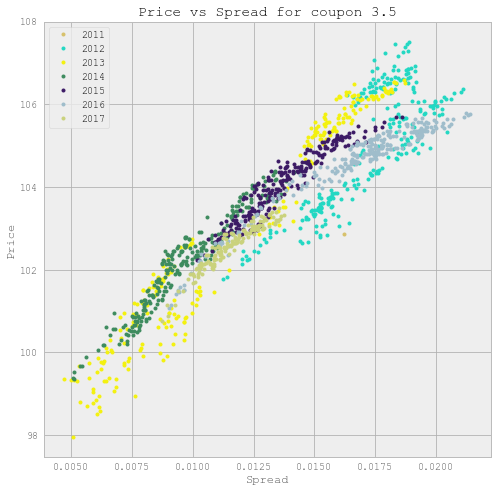

In [16]:
plot_setting(data=df_3,x="spread3_5",y='Price3.5',title='Price vs Spread for coupon 3.5')
plt.show()

# 1. Rolling Regression

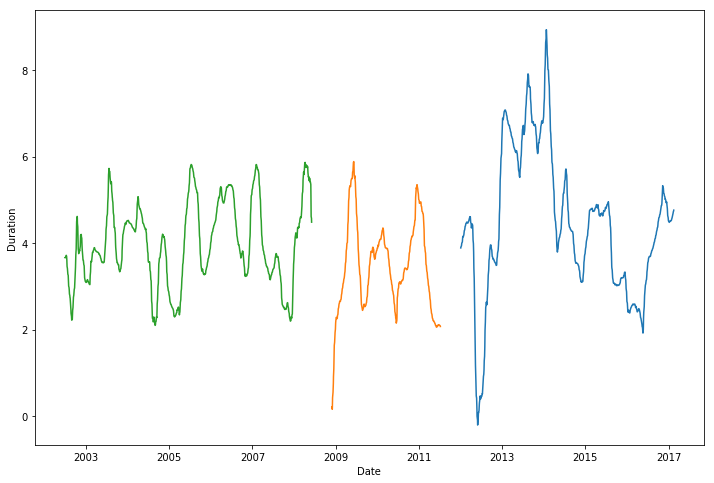

In [37]:
precision = 4

def regression_roll_wind(wind , df):
    beta = []
    for i in range((len(df)-wind)):
        
        dff = df.ix[i:i+wind].copy()
        
        mod = sm.OLS(dff['PX_MID'].values , sm.add_constant(dff['Spread'].values))
        res = mod.fit()
        a, b = res.params
        beta.append(b)
        
    return beta

FNCL_last_T = pd.DataFrame(regression_roll_wind(120,New_T),index=New_T.index[:-120])
FNCL_last_S = pd.DataFrame(regression_roll_wind(120,New_S),index=New_S.index[:-120])
FNCL_last_F = pd.DataFrame(regression_roll_wind(120,New_F),index=New_F.index[:-120])

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

ax.plot(FNCL_last_T.index,FNCL_last_T[0])
ax.plot(FNCL_last_S.index,FNCL_last_S[0])
ax.plot(FNCL_last_F.index,FNCL_last_F[0])

ax.set_xlabel('Date')
ax.set_ylabel('Duration')


# 3. Yearly Based Regression

Run regression on TBA against spread for each year

In [11]:
precision = 4

def reg(year, fig):
    dff = Merged_df.iloc[(Merged_df.index < dt.datetime(year+1,1,1)) & \
                         (Merged_df.index > dt.datetime(year-1,12,31))].copy()
    mod = sm.OLS(dff['PX_MID'].values , sm.add_constant(dff['spread'].values))
    res = mod.fit()
    a, b = res.params
    x = np.linspace(min(dff['spread'].values),max(dff['spread'].values))
    y = [a+b*i for i in x]
    ax = fig.add_subplot(8,2,year - 2001)
    ax.plot(x, y,color = 'r',label='fit')
    ax.scatter(dff['spread'].values,dff['PX_MID'].values,label = 'real',s=4)
    symb = ' + ' if b >= 0 else ''
    ax.set_title('year ' + str(year) + ' : ' + str(round(a, precision)) + symb + str(round(b, precision)) + 'x')
    ax.legend()
    ax.set_xlabel('spread')
    ax.set_ylabel('TBA')
    
    return b

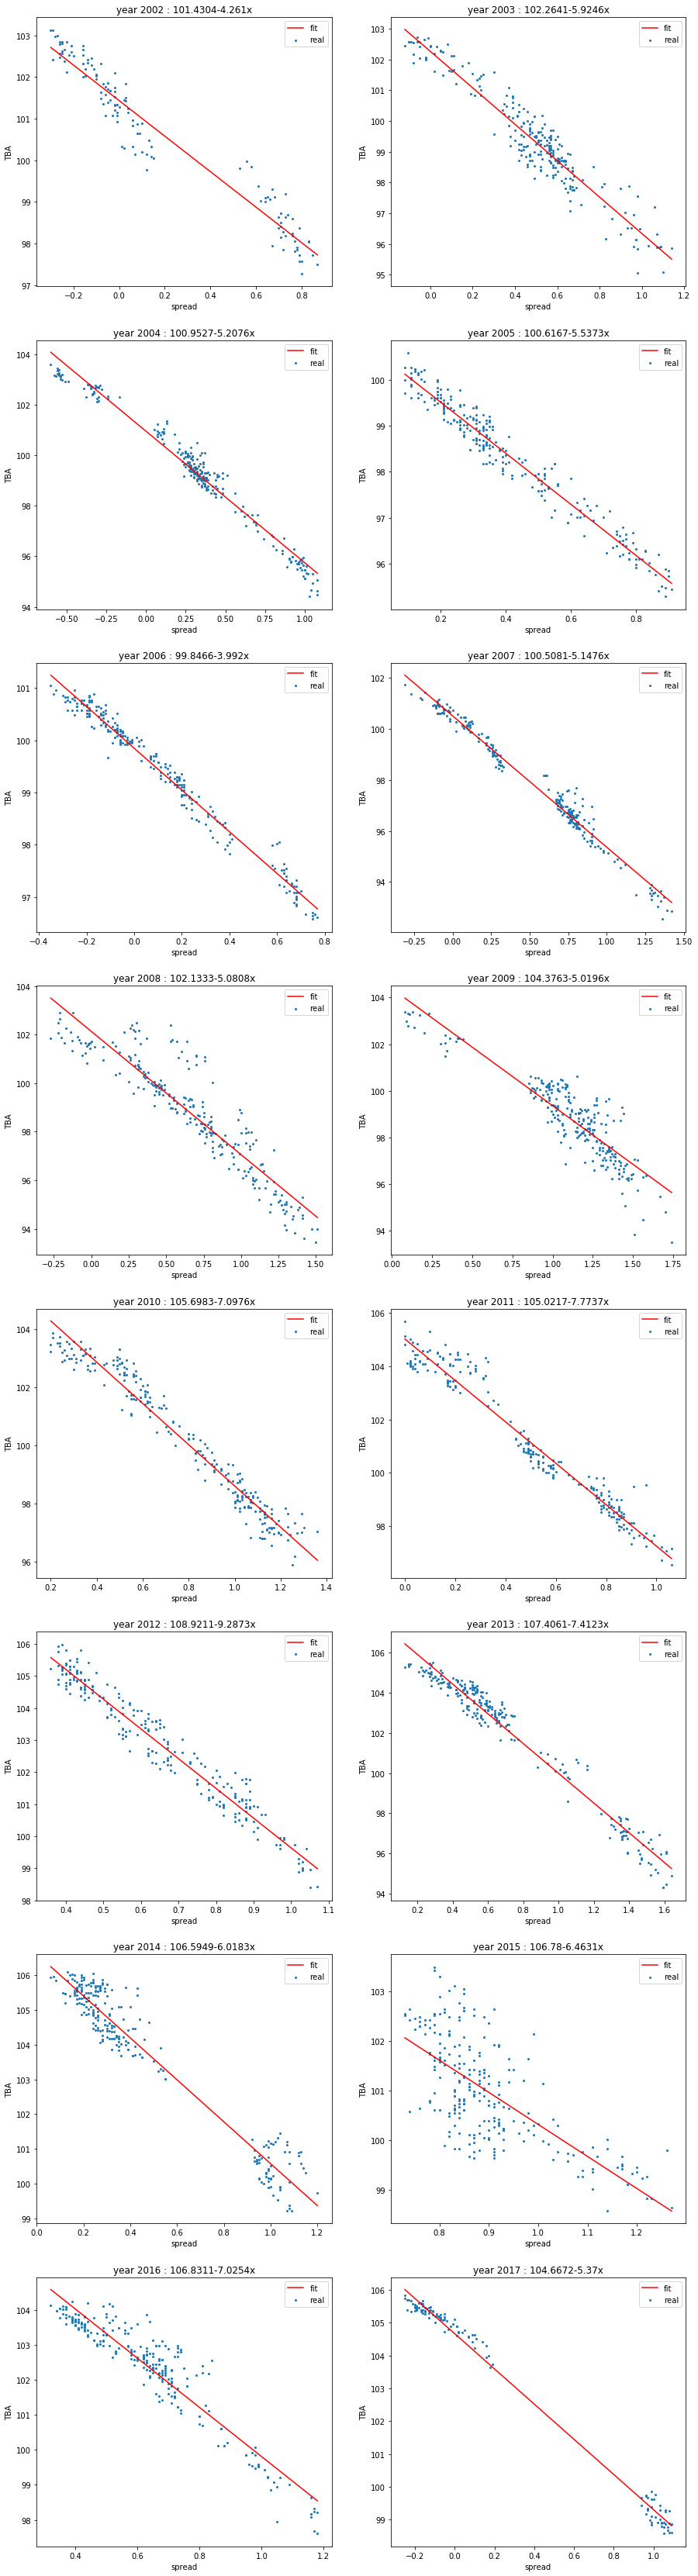

In [145]:
fig = plt.figure(figsize = (15, 60))
ds = []

for i in range(2002,2018):
    ds.append(reg(i, fig))

**Duration change against time**

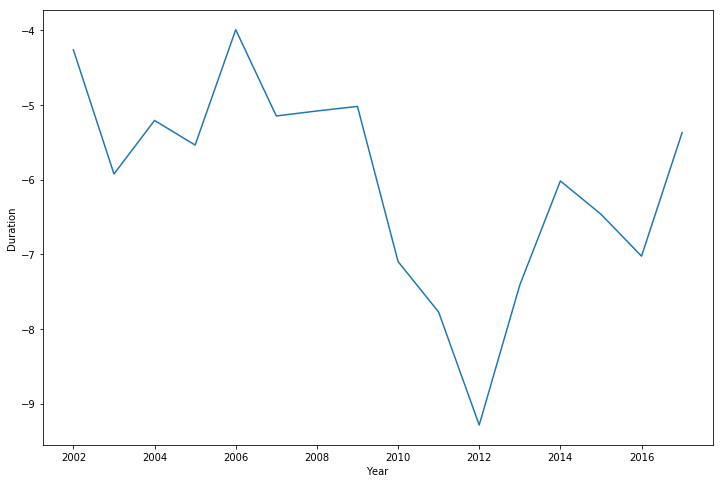

In [122]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(2002, 2018), ds)
ax.set_xlabel('Year')
ax.set_ylabel('Duration')

# 4. Coupon Period Regression

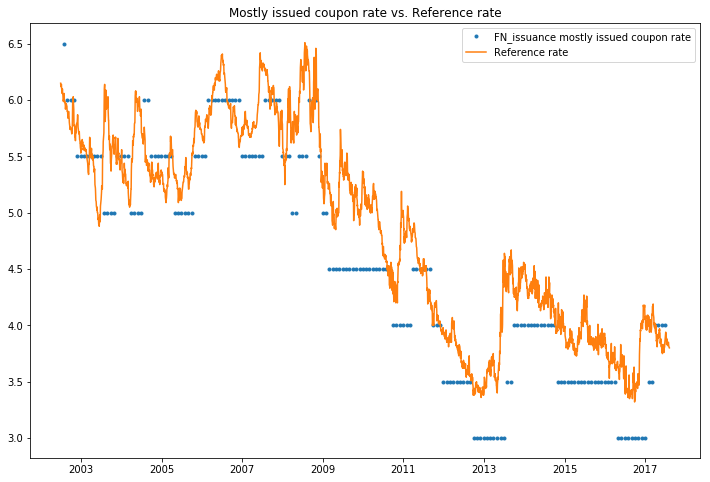

In [125]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 3)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

**The chart shows coupon rate are constant during certain periods. We choose the constant coupon rate period as rolling window. The intuition is that change in mostly issued coupon rate is due to changes in some fundamental factors to be explored. So within a constant coupon period, we could consider it as a constant regime**

In [141]:
samples = []
cur_coupon = Merged_df.iloc[0].coupon
start_index = 0
for i in np.arange(1, Merged_df.shape[0]):
    if Merged_df.iloc[i].coupon != cur_coupon:
        samples.append(Merged_df.iloc[start_index:i-1])
        start_index = i
        cur_coupon = Merged_df.iloc[i].coupon
samples.append(Merged_df.iloc[start_index:Merged_df.shape[0] - 1])

In [162]:
Merged_df.index.values

array(['2017-06-30T00:00:00.000000000', '2017-06-29T00:00:00.000000000',
       '2017-06-28T00:00:00.000000000', ...,
       '2002-07-03T00:00:00.000000000', '2002-07-02T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

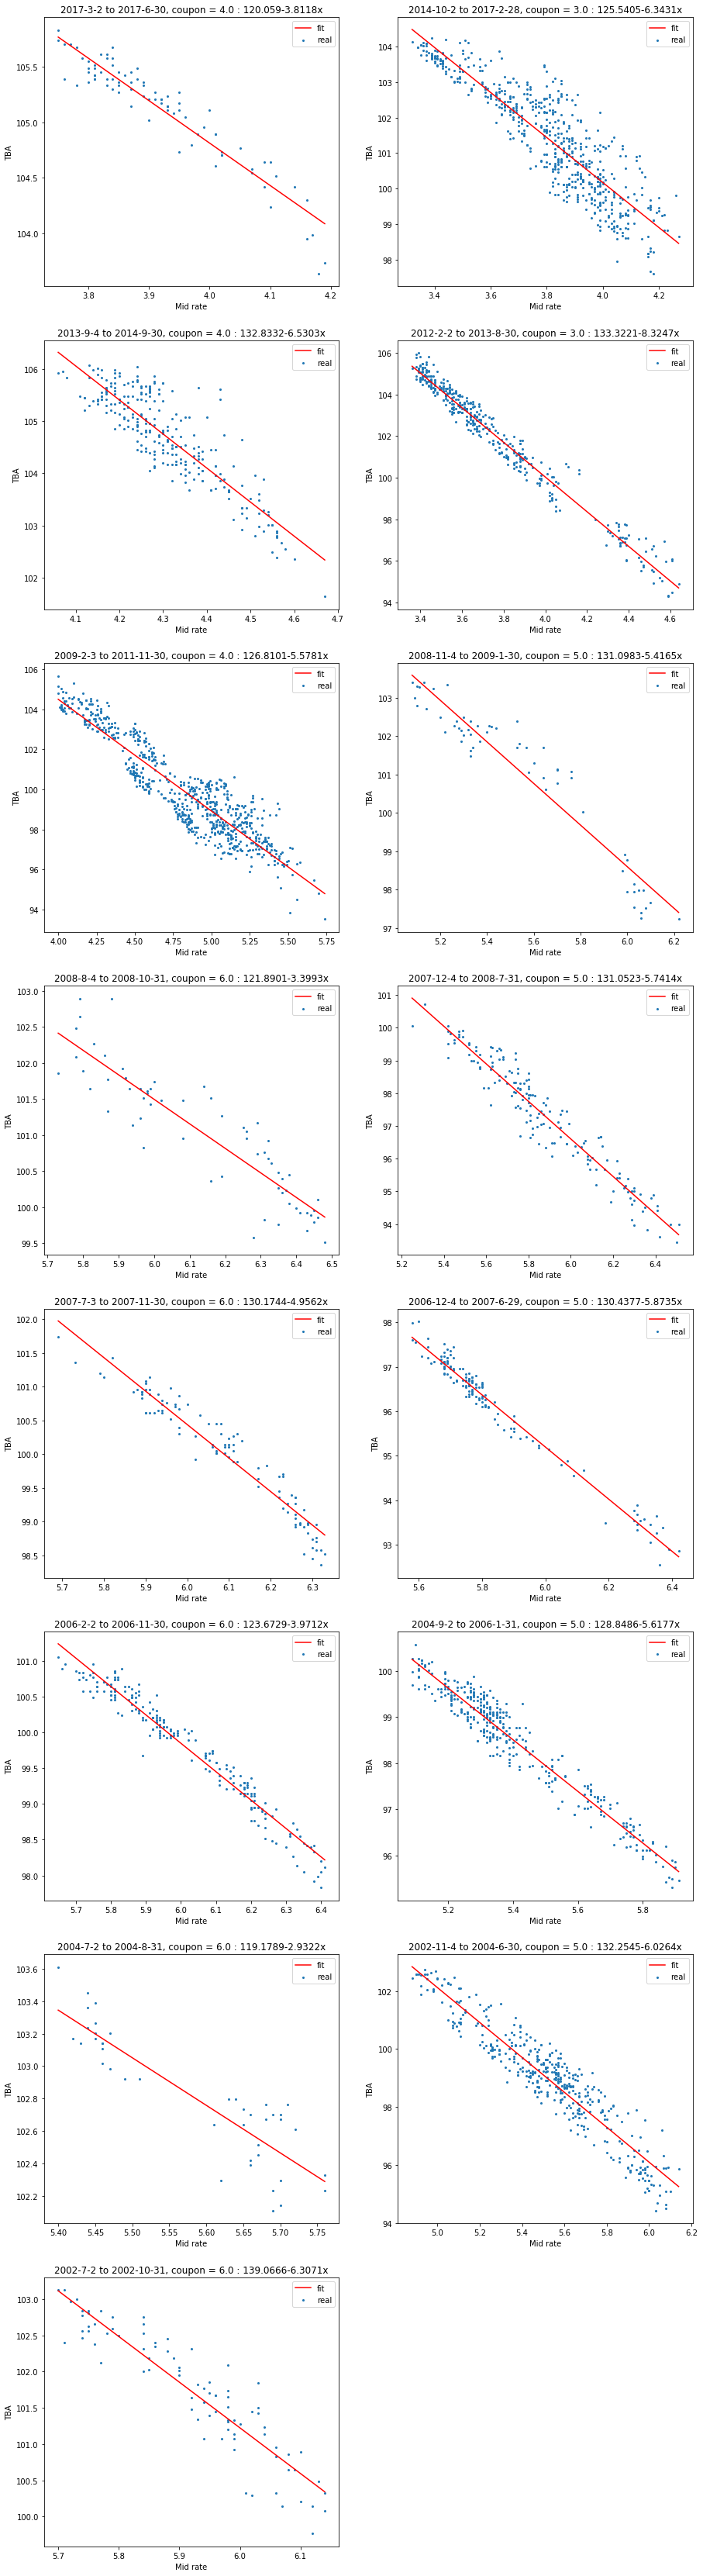

In [169]:
i = 1
fig = plt.figure(figsize = (15, 60))
ds2 = []
for s in samples:
    mod = sm.OLS(s['PX_MID'].values , sm.add_constant(s['Mid rate'].values))
    res = mod.fit()
    a, b = res.params
    x = np.linspace(min(s['Mid rate'].values),max(s['Mid rate'].values))
    y = [a+b*i for i in x]
    ax = fig.add_subplot(8,2,i)
    i = i + 1
    ax.plot(x, y,color = 'r',label='fit')
    ax.scatter(s['Mid rate'].values,s['PX_MID'].values,label = 'real',s=4)
    symb = ' + ' if b >= 0 else ''
    time_start = '{}-{}-{}'.format(s.iloc[s.shape[0] - 1].name.year, s.iloc[s.shape[0] - 1].name.month, s.iloc[s.shape[0] - 1].name.day)
    time_end = '{}-{}-{}'.format(s.iloc[0].name.year, s.iloc[0].name.month, s.iloc[0].name.day)
    ax.set_title(time_start + ' to ' + time_end + ', coupon = ' + str(s.iloc[0].coupon) + ' : ' + str(round(a, precision)) + symb + str(round(b, precision)) + 'x')
    ax.legend()
    ax.set_xlabel('Mid rate')
    ax.set_ylabel('TBA')
    
    ds2.append(pd.DataFrame({'Date' : s.index.values, 'Duration' : np.ones(s.shape[0]) * b}))

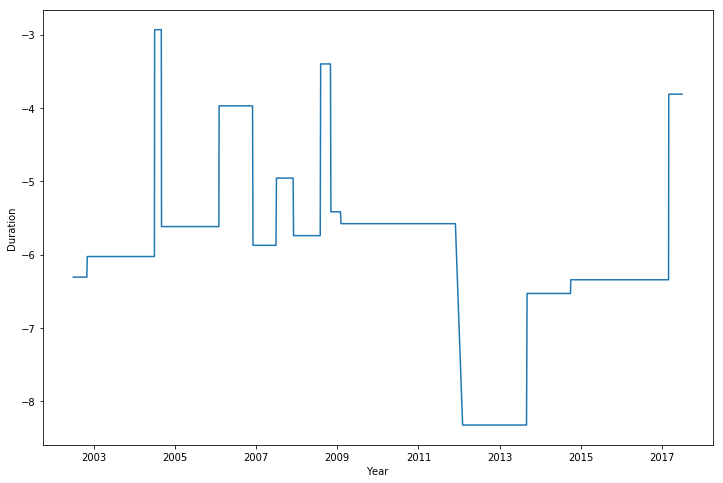

In [172]:
res = pd.concat(ds2)
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(res.Date, res.Duration)
ax.set_xlabel('Year')
ax.set_ylabel('Duration')